In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt

plt.ion()  #interactive mode

In [2]:
#Loading data
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader=torch.utils.data.DataLoader(
    datasets.MNIST(root='./mnist',train=True,download=True,transform=transforms.Compose([
        transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))
    ])),batch_size=64,shuffle=True,num_workers=4)
test_loader=torch.utils.data.DataLoader(
    datasets.MNIST(root='./mnist',train=False,transform=transforms.Compose([
        transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))
    ])),batch_size=64,shuffle=True,num_workers=4)
print(device)

cuda


In [3]:
#Depicting STN
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
        
        #Spatial transformer localization-network
        self.localization=nn.Sequential(
            nn.Conv2d(1,8,kernel_size=7),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU(True),
            nn.Conv2d(8,10,kernel_size=5),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU(True)
        )
        #Regressor for the 3*2 affine matrix
        self.fc_loc=nn.Sequential(
            nn.Linear(10*3*3,32),
            nn.ReLU(True),
            nn.Linear(32,3*2)
        )
        #Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0],dtype=torch.float))
    #STN forward function
    def stn(self,x):
        xs=self.localization(x)
        xs=xs.view(-1,10*3*3)
        theta=self.fc_loc(xs)
        theta=theta.view(-1,2,3)
        grid=F.affine_grid(theta,x.size())
        x=F.grid_sample(x,grid)
        return x
    def forward(self,x):
        #transform the input
        x=self.stn(x)
        #perform the usual forward pass
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x,dim=1)
model=Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [4]:
#Training the model
optimizer=optim.SGD(model.parameters(),lr=0.001)
def train(epoch):
    model.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        output=model(data)
        loss=F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx%500==0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch,batch_idx*len(data),len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))
#A simple test procedure to measure STN the performance on MNIST
def test():
    with torch.no_grad():
        model.eval()
        test_loss=0.0
        correct=0
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=model(data)
            #sum up batch loss
            test_loss+=F.nll_loss(output,target,size_average=False).item()
            #get the index of max log probability
            pred=output.max(1,keepdim=True)[1]
            correct+=pred.eq(target.view_as(pred)).sum().item()
        test_loss/=len(test_loader.dataset)
        print('\nTest set:Average loss: {:.4f},Accuracy: {}/{} ({:.0f}%)\n'.format(
                                    test_loss,correct,len(test_loader.dataset),100.*correct/len(test_loader.dataset)))
for epoch in range(1,20+1):
    train(epoch)
    test()

Train epoch: 1 [0/60000 (0%)]	 Loss: 2.320503
Train epoch: 1 [32000/60000 (53%)]	 Loss: 2.247193


C:\Users\13051\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set:Average loss: 2.2080,Accuracy: 3291/10000 (33%)

Train epoch: 2 [0/60000 (0%)]	 Loss: 2.196327
Train epoch: 2 [32000/60000 (53%)]	 Loss: 2.154889

Test set:Average loss: 1.8470,Accuracy: 5905/10000 (59%)

Train epoch: 3 [0/60000 (0%)]	 Loss: 1.916653
Train epoch: 3 [32000/60000 (53%)]	 Loss: 1.674397

Test set:Average loss: 1.0738,Accuracy: 7860/10000 (79%)

Train epoch: 4 [0/60000 (0%)]	 Loss: 1.225688
Train epoch: 4 [32000/60000 (53%)]	 Loss: 1.220575

Test set:Average loss: 0.5498,Accuracy: 8811/10000 (88%)

Train epoch: 5 [0/60000 (0%)]	 Loss: 0.832433
Train epoch: 5 [32000/60000 (53%)]	 Loss: 0.718891

Test set:Average loss: 0.3566,Accuracy: 9117/10000 (91%)

Train epoch: 6 [0/60000 (0%)]	 Loss: 0.779314
Train epoch: 6 [32000/60000 (53%)]	 Loss: 0.616300

Test set:Average loss: 0.2528,Accuracy: 9352/10000 (94%)

Train epoch: 7 [0/60000 (0%)]	 Loss: 0.448286
Train epoch: 7 [32000/60000 (53%)]	 Loss: 0.570060

Test set:Average loss: 0.2153,Accuracy: 9419/10000 (94%)

Train

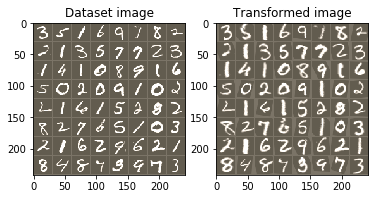

In [5]:
#Visualizing STN result
def convert_image_np(inp):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    return inp

#可视化spatial transformation layer的输出
def visualize_stn():
    with torch.no_grad():
        #Get a batch of training data
        data=next(iter(test_loader))[0].to(device)
        input_tensor=data.cpu()
        transformed_input_tensor=model.stn(data).cpu()
        in_grid=convert_image_np(torchvision.utils.make_grid(input_tensor))
        out_grid=convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))
        
        #plot the result side-by-side
        f,axarr=plt.subplots(1,2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset image')
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed image')    

#Visualize the STN transformation on some batch
visualize_stn()
plt.ioff()
plt.show()

In [7]:
print('Pytorch Version:',torch.__version__)
print('Torchvision Version:',torchvision.__version__)

Pytorch Version: 1.0.0
Torchvision Version: 0.2.1


In [8]:
import caffe2